In [1]:

%matplotlib inline
import os, glob, string, sys, time, random, numpy
from numpy import zeros,array
import matplotlib.pyplot as plt
import matplotlib as mpl

def read_dataset(f):
    input=open(f)
    lines=input.readlines()
    data=zeros( (len(lines),2) )
    labels=zeros( (len(lines),1) ) 
    for i,l in enumerate(lines):
        v=[float(t) for t in l.split()]
        data[i,0]=v[0]
        data[i,1]=v[1]
        labels[i]=v[2]
    input.close()
    return data,labels

## Exercise 2.1

Let's first plot the precision@k for the two different systems:

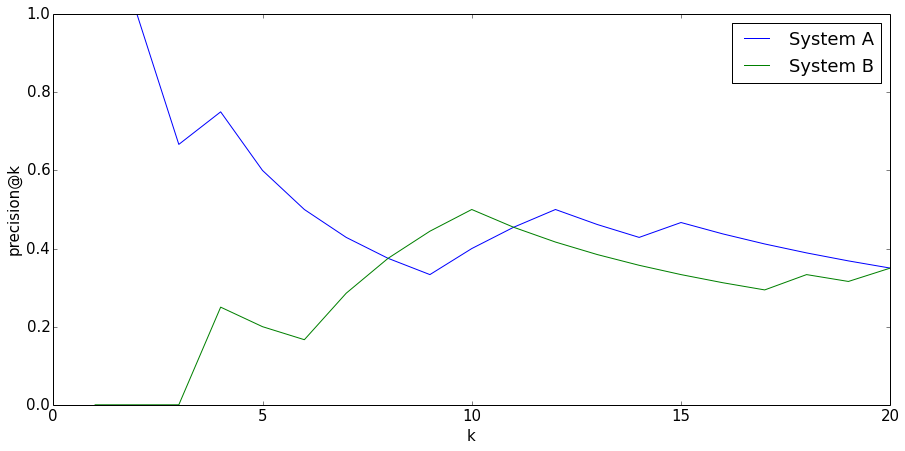

In [8]:
# The data
system_a = [1,1,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0] # 1 indicating relevant result
system_b = [0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,0,1]

# Function to compute precision at k
precision = lambda sequence, k: sum(sequence[:k])*1./k

# Displaying options
plt.figure(figsize=(15,7))
mpl.rcParams.update({'font.size': 15})
plt.xlabel('k')
plt.ylabel('precision@k')

# Plotting
plt.plot(range(1,21), map(lambda k: precision(system_a,k), range(1,21)), label='System A')
plt.plot(range(1,21), map(lambda k: precision(system_b,k), range(1,21)), label='System B')

plt.legend() # display the legend

In [3]:
R = sum(system_a) # total number of relevant documents

# Function to compute the average precision
# Note that we only consider those k where a new relevant document is added to the list.
average_precision = lambda sequence:\
    sum([precision(sequence,k+1) for k in range(len(sequence)) if sequence[k]])*1./R

# Compute and print average precision for both systems
print 'Average Precision'
print '-'*20
print 'System A: %f'%average_precision(system_a)
print 'System B: %f'%average_precision(system_b)

Average Precision
--------------------
System A: 0.653030
System B: 0.362642


In this case we only have performances for a single query. Hence, the mean average precision is the same as the average precision.

N.B.: If we had results for multiple queries, we would (for each system separately) compute the average precision for each individual query and then compute the average over all queries to obtain the mean average precision of that system.

### Which system is better?

First of all, 20 results for a single query is in general not enough to tell which system is better since you want to base such a statement on significant differences.

Asides from that, it still depends on how you define "better" (and "uniformly better"). Some possible definitions and their implications would be:
- "A system is better than another system if its mean average precision is higher." In this case system A is better than system B.
- "A system is better than another system if its precision@k is higher." (For some given k.) In this case system A may or may not be better than system B, depending on the specific choice for k.
- "A system is uniformly better than another system if its mean average precision is higher." In this case again system A is better.
- "A system is uniformly better than another system if its precision@k is higher for all k." In this case no system is uniformly better than the other system.

N.B.: Finding a suitable evaluation method (i.e. defining what "good" results are) is often far from trivial in machine learning.

## Exercise 2.2

Bit more realistic (and formally correct) formulation:

You have a large set of documents. For a given query, you now want to get the relevant documents in form of a ranked list. (Think of a search engine.)

Your system does the ranking by extracting features from the document and estimating the probability that the document is relevant, given its feature values. Documents with high likelihood of relevance should then appear early in the list.

We consider this as a random process and introduce a few notations:
- $R$: random variable that is $1$ if a given document is relevant and $0$ if it's not relevant
- $F$: random variable that describes the values of the feature vector
- $f(d)$: features of document $d$

For a given document $d$, we can now formally state the probability we want the system to calculate:

$$ P(R = 1 \mid F = f(d)) $$

With Bayes' Theorem and marginilization this rewrites as:

$$ P(R = 1 \mid F = f(d)) = \frac{P(F = f(d) \mid R = 1) \cdot P(R = 1)}{P(F = f(d))} $$

We can estimate the probabilities $P(F = f(d))$ and $ P(F = f(d) \mid R = 1)$ from a training set.

In principle we could also estimate $P(R = 1)$ but it turns out that we don't need to compute this number if we are just interested in the ranking and not in the actual probabilities since it has the same value for all documents and hence doesn't affect the ranking at all:

\begin{align} P(R = 1 \mid F = f(d_1)) &> P(R = 1 \mid F = f(d_2)) \\
\Leftrightarrow \frac{P(F = f(d_1) \mid R = 1) \cdot P(R = 1)}{P(F = f(d_1))} &> \frac{P(F = f(d_2) \mid R = 1) \cdot P(R = 1)}{P(F = f(d_2))} \\
\Leftrightarrow \frac{P(F = f(d_1) \mid R = 1)}{P(F = f(d_1))} &> \frac{P(F = f(d_2) \mid R = 1)}{P(F = f(d_2))}
\end{align}

for any documents $d_1$ and $d_2$.


### Additional details

- Estimating $P(F = f(d) \mid R = 1)$ from the training set can be straight-forward: Count the number of relevant documents in the training set that have features $f(d)$ and divide that number by the total number of relevant documents in the training set. (Assuming each document is equally likely.) N.B.: In practice you would generally not do it in this naive way, especially for high dimensional $f(d)$.
- Often people just write $P(R \mid f(d))$ instead of $P(R = 1 \mid F = f(d))$ (which can be quite dangerous if you are not that familiar with stochastics).


### Some (optional) questions

- How would you actually change the prior $P(R = 1)$? Can you change it independently from the other probabilities?



### References

[1] http://nlp.stanford.edu/IR-book/pdf/11prob.pdf


## Exercise 2.3

In [189]:
# distance measure
import math
def distance(p1,p2,d=2):
    distance = 0
    # Calculate euclidean 
    for f in range(d):
        distance += pow((p1[f] - p2[f]), 2)
    return math.sqrt(distance)

# Get Majority
def get_descision(ns):
    zeros,ones = 0,0
    for n,d in ns:
        if n[2] == 0:
            zeros += 1
        else:
            ones += 1
    if zeros > ones:
        return 0
    return 1
    

# Return neighbours
def kNearest(train_set, in_point, K=5):
    # euclidean distances
    euc_dists = []
    for p in train_set:
        # list of tuples of (p, distance to p)
        euc_dists.append((p,distance(in_point, p, 2)))
    # Sort w.r.t distances and return first K
    return sorted(euc_dists,key=lambda x:x[1])[:K]


def classify(train_fname, test_fname, K=3):
    # Import data into arrays
    train_ds,train_ls = read_dataset(train_fname)
    test_ds,test_ls = read_dataset(test_fname)
    train_set = np.hstack((train_ds,train_ls))
    test_set = np.hstack((test_ds,test_ls))
    #
    #create a prediction set to store the predicted values
    #make it the same shape of test_set
    pred_set = np.hstack((test_ds,np.zeros(test_ls.shape)))
    for i,sample in enumerate(test_set):
        k_ns = kNearest(train_set, sample, K)
        pred_label = get_descision(k_ns)
        pred_set[i,2] = pred_label
    plot_data([train_set,test_set,pred_set])
    print test_accuracy(test_set,pred_set)

def test_accuracy(test,pred):
    hits = 0
    # 0 means it was hit and non zero means miss
    h = test[:,2] - pred[:,2]
    return len(h[h==0])/(len(h)*1.0)*100


In [190]:
import numpy as np
# plot 
def plot_data(data):
    # data in the form of list of array of n*3 matrices
    n_subplots = len(data)
    fig, axs = plt.subplots(n_subplots,figsize=(8,8))
    #TODO : Remove this dependency
    axs[0].set_title("Train Set")
    axs[1].set_title("Test Set")
    axs[2].set_title("Pred Set")
    # create a map for colors
    colors = ['red', 'blue']
    lvls = [0, 1]
    cmap, norm = mpl.colors.from_levels_and_colors(levels=lvls, colors=colors, extend='max')
    for i in range(n_subplots):
        axs[i].scatter(data[i][:,0],data[i][:,1],c=data[i][:,2],cmap=cmap, norm=norm)
    


88.3333333333


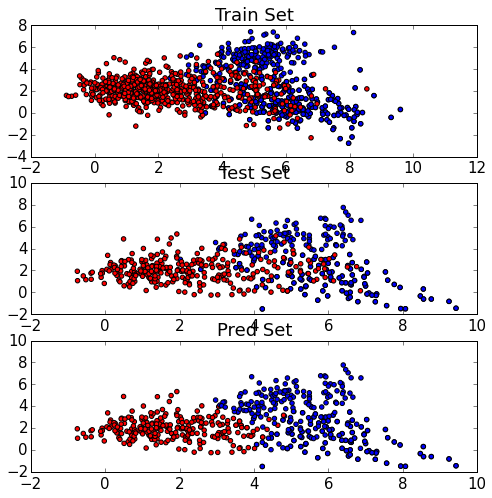

In [191]:
classify("train-large.txt","test.txt",50)